In [37]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# Feature
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors

# Modeling
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# Membaca data
train_data = pd.read_csv('../../Data/5. Split/train_data.csv')
validation_data = pd.read_csv('../../Data/5. Split/validation_data.csv')
test_data = pd.read_csv('../../Data/5. Split/test_data.csv')

In [39]:
# Memisahkan fitur dan label untuk setiap bagian dataset
x_train = train_data.text_manual_replaced
y_train = train_data.label

x_validation = validation_data.text_manual_replaced
y_validation = validation_data.label

x_test = test_data.text_manual_replaced
y_test = test_data.label

Word2Vec

In [40]:
# Memuat model Word2Vec CBOW yang telah disimpan
model_ug_cbow = KeyedVectors.load('./../../Model/w2v_model_ug_cbow.word2vec')

# Memuat model Word2Vec Skip-gram yang telah disimpan
model_ug_sg = KeyedVectors.load('./../../Model/w2v_model_ug_sg.word2vec')

In [41]:
# Menghitung jumlah kata unik dalam model Word2Vec CBOW
unique_words_count = len(model_ug_cbow.wv.index_to_key)

# Menampilkan jumlah kata unik
print(unique_words_count)

7350


In [42]:
embeddings_index = {}

# Menggabungkan kedua embeddings dari model CBOW dan Skip-gram untuk setiap kata unik
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])

# Menampilkan jumlah vektor kata yang ditemukan
print('Found %s word vectors.' % len(embeddings_index))

Found 7350 word vectors.


In [43]:
# Membuat tokenizer dengan jumlah kata maksimum 20.000
tokenizer = Tokenizer(num_words=1500)  # num_words adalah jumlah kosakata yang ingin digunakan

# Melatih tokenizer pada teks dari data latih
tokenizer.fit_on_texts(x_train)

# Mengonversi teks menjadi urutan bilangan bulat yang merepresentasikan indeks kata
sequences = tokenizer.texts_to_sequences(x_train)

In [44]:
# Menghitung jumlah kata unik dalam tokenizer
unique_token_count = len(tokenizer.word_index)

# Menampilkan jumlah kata unik
print(unique_token_count)

6287


In [45]:
# Menampilkan 5 teks pertama dari data latih (x_train)
for x in x_train[:5]:
    print(x)

obat yang larang kan sudah edar tahun banyak anak anak indonesia kalau panas batuk minum obat sebut baru sekarang ramai semua obat makan yang keluar edar ada ijin bpom edar juga ecek kadar apa saja yang kandung makan obat sebut kalau kadar nya enggak rugi masyarakat baru edar kalau bpom balik sudah makan banyak korban baru cek tarik pasar kan makan obat obat yang periksa parah sama badan yang satu sehat tubuh rakyat indonesia makan obat obat yang mutu lewat bpom yang beri amanah sehat rakyat indonesia makan obat obat yang halal kualitas salam waras
negara kumuh bersih hari sangat jauh sehat jorok kok sirup yang jadi kambing hitam
ada yang rencana tiba tiba ada yang jual obat luar dalam
gelar badut milik kominfo sekarang pindah menkes gyg menteri apa iya
iya bikin kacau lagi


In [46]:
# Menampilkan urutan indeks kata dari teks pertama dalam data latih (sequences)
print(sequences[:1])

[[1, 2, 109, 34, 13, 85, 56, 21, 3, 3, 22, 11, 101, 37, 6, 1, 119, 33, 24, 462, 25, 1, 40, 2, 296, 85, 44, 291, 16, 85, 46, 1000, 723, 10, 17, 2, 117, 40, 1, 119, 11, 723, 12, 5, 451, 93, 33, 85, 11, 16, 367, 13, 40, 21, 168, 33, 110, 238, 354, 34, 40, 1, 1, 2, 135, 324, 30, 344, 2, 136, 31, 332, 161, 22, 40, 1, 1, 2, 368, 16, 2, 127, 1477, 31, 161, 22, 40, 1, 1, 2, 835, 836, 493, 1478]]


In [47]:
length = []

# Menghitung jumlah kata dalam setiap teks dari data latih (x_train) dan menyimpannya dalam daftar length
for x in x_train:
    length.append(len(x.split()))

# length berisi panjang (jumlah kata) dari setiap teks dalam data latih

In [48]:
# Menghitung jumlah kata maksimum dalam satu kalimat dari data latih (x_train)
max_word_count = max(length)

# Menampilkan jumlah kata maksimum
print("Maximum number of words in a sentence:", max_word_count)

Maximum number of words in a sentence: 399


In [49]:
# Menetapkan panjang maksimum urutan (max_len) untuk padding
max_len = 400

# max_len digunakan untuk membatasi panjang urutan maksimum saat melakukan padding

In [50]:
# Melakukan padding pada urutan data latih (x_train) agar memiliki panjang yang sama (max_len)
x_train_seq = pad_sequences(sequences, maxlen=max_len)

# Menampilkan bentuk tensor data latih yang telah dipad (x_train_seq)
print('Shape of padded data tensor:', x_train_seq.shape)

Shape of padded data tensor: (3820, 400)


In [51]:
# Menampilkan 5 sampel pertama dari data latih yang telah dipad (x_train_seq)
print(x_train_seq[:5])


[[   0    0    0 ...  836  493 1478]
 [   0    0    0 ...    9  494  463]
 [   0    0    0 ...    1  252  194]
 [   0    0    0 ...  279   10   52]
 [   0    0    0 ...   83  577   78]]


In [52]:
# Mengonversi teks dalam data validasi (x_validation) menjadi urutan angka menggunakan tokenizer yang sama
sequences_val = tokenizer.texts_to_sequences(x_validation)

# Melakukan padding pada urutan data validasi agar memiliki panjang yang sama (max_len)
x_val_seq = pad_sequences(sequences_val, maxlen=max_len)

# Komentar: Sekarang, x_val_seq berisi data validasi yang telah dipad dan siap digunakan

In [53]:
# Menetapkan jumlah kata yang akan digunakan dalam matriks embedding
num_words = len(tokenizer.word_index) + 1

# Membuat matriks embedding kosong dengan bentuk (num_words, 200)
embedding_matrix = np.zeros((num_words, 200))

# Mengisi matriks embedding dengan vektor embedding yang sesuai dari embeddings_index
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Komentar: embedding_matrix sekarang berisi vektor embedding untuk seluruh kata unik dalam tokenizer.word_index

In [54]:
# Memeriksa kesetaraan antara vektor embedding ke-29 dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[29], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'? False


In [55]:
# Cari indeks kata 'baik' dalam tokenizer.word_index
baik_index = tokenizer.word_index.get('baik')

# Memeriksa kesetaraan antara vektor embedding kata 'baik' dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[baik_index], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'? True


In [56]:
# Ubah label menjadi one-hot encoding
y_train_cat = to_categorical(y_train + 1, num_classes=3)
y_validation_cat = to_categorical(y_validation + 1, num_classes=3)

Pemodelan LSTM

In [57]:
# Membangun model LSTM
model_lstm = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang tidak dapat dilatih
model_lstm.add(Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False))

# Menambahkan lapisan SpatialDropout1D
model_lstm.add(SpatialDropout1D(0.2))

# Menambahkan lapisan LSTM
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# Menambahkan lapisan Dense dengan fungsi aktivasi ReLU
model_lstm.add(Dense(256, activation='relu'))

# Menambahkan lapisan Dense dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_lstm.add(Dense(3, activation='softmax'))

# Mengkompilasi model LSTM
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menampilkan ringkasan model
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 400, 200)          1257600   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 400, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 100)               120400    
                                                                 
 dense_6 (Dense)             (None, 256)               25856     
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,404,627
Trainable params: 147,027
Non-trainable params: 1,257,600
______________________________________

In [58]:
# Melatih model dengan data latih dan validasi (gunakan y_train_cat dan y_validation_cat untuk label one-hot encoded)
model_lstm.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 73s - loss: 0.9421 - accuracy: 0.5620 - val_loss: 0.9069 - val_accuracy: 0.6004 - 73s/epoch - 606ms/step
Epoch 2/5
120/120 - 72s - loss: 0.8253 - accuracy: 0.6466 - val_loss: 0.8430 - val_accuracy: 0.6276 - 72s/epoch - 596ms/step
Epoch 3/5
120/120 - 70s - loss: 0.7737 - accuracy: 0.6683 - val_loss: 0.8478 - val_accuracy: 0.6255 - 70s/epoch - 586ms/step
Epoch 4/5
120/120 - 71s - loss: 0.7369 - accuracy: 0.6838 - val_loss: 0.8687 - val_accuracy: 0.6255 - 71s/epoch - 590ms/step
Epoch 5/5
120/120 - 72s - loss: 0.6840 - accuracy: 0.7175 - val_loss: 0.8300 - val_accuracy: 0.6444 - 72s/epoch - 599ms/step


In [59]:
# Membangun model LSTM
model_lstm_02 = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang tidak dapat dilatih
model_lstm_02.add(Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False))

# Menambahkan lapisan SpatialDropout1D
model_lstm_02.add(SpatialDropout1D(0.5))

# Menambahkan lapisan LSTM
model_lstm_02.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Menambahkan lapisan Dense dengan fungsi aktivasi ReLU
model_lstm_02.add(Dense(256, activation='relu'))

# Menambahkan lapisan Dropout
model_lstm_02.add(Dropout(0.5))

# Menambahkan lapisan Dense dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_lstm_02.add(Dense(3, activation='softmax'))

# Mengkompilasi model LSTM
model_lstm_02.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menampilkan ringkasan model
model_lstm_02.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 400, 200)          1257600   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 400, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 128)               168448    
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                      

In [60]:
# Melatih model dengan data latih dan validasi
model_lstm_02.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 102s - loss: 1.0110 - accuracy: 0.5073 - val_loss: 0.9398 - val_accuracy: 0.5711 - 102s/epoch - 850ms/step
Epoch 2/5
120/120 - 100s - loss: 0.9101 - accuracy: 0.5919 - val_loss: 0.8878 - val_accuracy: 0.6004 - 100s/epoch - 836ms/step
Epoch 3/5
120/120 - 101s - loss: 0.8765 - accuracy: 0.6052 - val_loss: 0.8689 - val_accuracy: 0.6213 - 101s/epoch - 841ms/step
Epoch 4/5
120/120 - 100s - loss: 0.8433 - accuracy: 0.6298 - val_loss: 0.8785 - val_accuracy: 0.6130 - 100s/epoch - 836ms/step
Epoch 5/5
120/120 - 100s - loss: 0.8358 - accuracy: 0.6296 - val_loss: 0.9101 - val_accuracy: 0.5753 - 100s/epoch - 833ms/step


In [61]:
# Membangun model LSTM
model_lstm_03 = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang tidak dapat dilatih
model_lstm_03.add(Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False))

# Menambahkan lapisan SpatialDropout1D
model_lstm_03.add(SpatialDropout1D(0.2))

# Menambahkan lapisan LSTM
model_lstm_03.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

# Menambahkan lapisan Conv1D
model_lstm_03.add(Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform"))

# Menambahkan lapisan GlobalMaxPooling1D
model_lstm_03.add(GlobalMaxPooling1D())

# Menambahkan lapisan Dropout
model_lstm_03.add(Dropout(0.5))

# Menambahkan lapisan Dense dengan fungsi aktivasi ReLU
model_lstm_03.add(Dense(256, activation='relu'))

# Menambahkan lapisan Dropout
model_lstm_03.add(Dropout(0.5))

# Menambahkan lapisan Dense dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_lstm_03.add(Dense(3, activation='softmax'))

# Mengkompilasi model LSTM
model_lstm_03.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_03.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 400, 200)          1257600   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 400, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 400, 128)          168448    
                                                                 
 conv1d_1 (Conv1D)           (None, 398, 64)           24640     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [62]:
# Melatih model dengan data latih dan validasi
model_lstm_03.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 109s - loss: 1.0204 - accuracy: 0.4953 - val_loss: 0.9059 - val_accuracy: 0.6046 - 109s/epoch - 910ms/step
Epoch 2/5
120/120 - 108s - loss: 0.8946 - accuracy: 0.6045 - val_loss: 0.8667 - val_accuracy: 0.6213 - 108s/epoch - 899ms/step
Epoch 3/5
120/120 - 110s - loss: 0.8581 - accuracy: 0.6306 - val_loss: 0.8663 - val_accuracy: 0.6276 - 110s/epoch - 916ms/step
Epoch 4/5
120/120 - 107s - loss: 0.8241 - accuracy: 0.6613 - val_loss: 0.8507 - val_accuracy: 0.6360 - 107s/epoch - 891ms/step
Epoch 5/5
120/120 - 107s - loss: 0.7978 - accuracy: 0.6717 - val_loss: 0.8173 - val_accuracy: 0.6527 - 107s/epoch - 891ms/step


Evaluasi Pemodelan LSTM

In [64]:
model_1_eval = model_lstm.evaluate(x_val_seq, y_validation_cat, verbose=0)
print("Akurasi validasi model eksperimen 1: {:.2f}%".format(model_1_eval[1] * 100))

model_2_eval = model_lstm_02.evaluate(x_val_seq, y_validation_cat, verbose=0)
print("Akurasi validasi model eksperimen 2: {:.2f}%".format(model_2_eval[1] * 100))

model_3_eval = model_lstm_03.evaluate(x_val_seq, y_validation_cat, verbose=0)
print("Akurasi validasi model eksperimen 3: {:.2f}%".format(model_3_eval[1] * 100))

Akurasi validasi model eksperimen 1: 64.44%
Akurasi validasi model eksperimen 2: 57.53%
Akurasi validasi model eksperimen 3: 65.27%


In [65]:
# Evaluasi model terbaik menggunakan data validasi
val_loss, val_accuracy = model_lstm_03.evaluate(x=x_val_seq, y=y_validation_cat)

15/15 [==============================] - 3s 189ms/step - loss: 0.8173 - accuracy: 0.6527


In [66]:
# Mengkonversi teks dalam x_test menjadi urutan token dengan tokenizer
sequences_test = tokenizer.texts_to_sequences(x_test)

# Melakukan padding pada urutan token agar memiliki panjang yang sama
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

# Mengubah label y_test menjadi bentuk one-hot encoding
y_test_cat = to_categorical(y_test + 1, num_classes=3) 

In [67]:
# Menilai model LSTM yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
LSTM_model_evaluation = model_lstm_03.evaluate(x=x_test_seq, y=y_test_cat)

# Memprediksi label kelas menggunakan model LSTM yang telah dilatih pada data test (x_test_seq)
yhat_lstm = model_lstm_03.predict(x_test_seq)

15/15 [==============================] - 3s 193ms/step


In [68]:
# Mengkonversi prediksi probabilitas ke label kelas untuk kedua model
y_pred_lstm = np.argmax(yhat_lstm, axis=1) - 1

# Menghitung true label dari one-hot encoding
y_true = np.argmax(y_test_cat, axis=1) - 1

In [69]:
# Menampilkan classification report untuk kedua model
print("Classification Report (LSTM Model):")
print(classification_report(y_true, y_pred_lstm))

Classification Report (LSTM Model):
              precision    recall  f1-score   support

          -1       0.67      0.70      0.68       158
           0       0.71      0.74      0.72       180
           1       0.63      0.56      0.59       140

    accuracy                           0.67       478
   macro avg       0.67      0.67      0.67       478
weighted avg       0.67      0.67      0.67       478



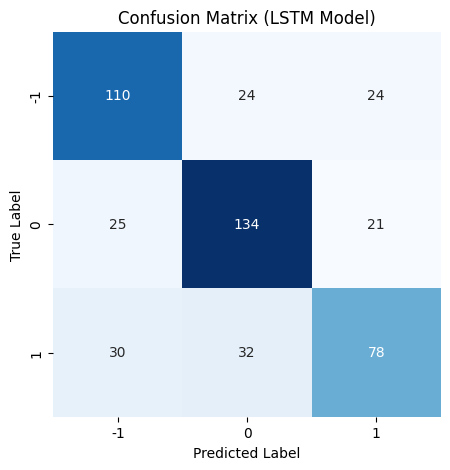

In [70]:
# Menghitung confusion matrix untuk kedua model
cm_lstm = confusion_matrix(y_true, y_pred_lstm)

# Fungsi untuk visualisasi confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Menampilkan visualisasi confusion matrix untuk kedua model
plot_cm(cm_lstm, "Confusion Matrix (LSTM Model)")

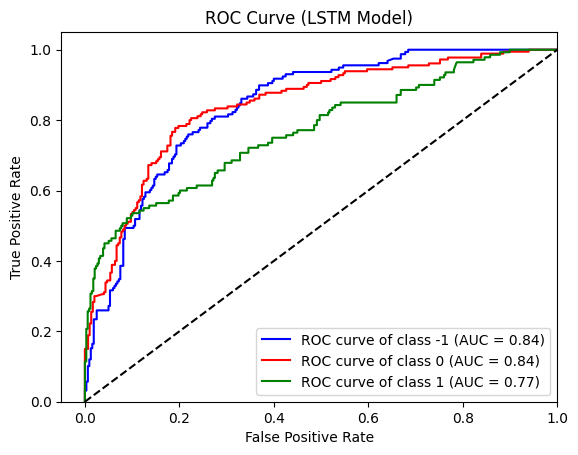

In [71]:
# Fungsi untuk menggambarkan ROC curve
def plot_roc_curve(y_true, y_score, n_classes, title):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])

    # Menghitung ROC curve dan AUC untuk setiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Menggambarkan ROC curve
    plt.figure()
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Menggambarkan ROC curve untuk kedua model
plot_roc_curve(y_true, yhat_lstm, n_classes=3, title='ROC Curve (LSTM Model)')

Output

In [73]:
# Gabungkan data latih, data validasi, dan data uji
full_data = pd.concat([train_data, validation_data, test_data], axis=0)

# Prediksi pada keseluruhan data
sequences_full = tokenizer.texts_to_sequences(full_data['text_manual_replaced'])
x_full_seq = pad_sequences(sequences_full, maxlen=max_len)
yhat_full_lstm = model_lstm_03.predict(x_full_seq)

# Konversi prediksi ke label kelas
yhat_full_lstm_classes = np.argmax(yhat_full_lstm, axis=1) - 1

# Tambahkan kolom baru ke DataFrame
full_data['predicted_sentiment'] = yhat_full_lstm_classes

full_data.head(10)

150/150 [==============================] - 29s 194ms/step


,text_manual_replaced,label,predicted_sentiment
0,obat yang larang kan sudah edar tahun banyak a...,-1,-1
1,negara kumuh bersih hari sangat jauh sehat jor...,-1,-1
2,ada yang rencana tiba tiba ada yang jual obat ...,0,0
3,gelar badut milik kominfo sekarang pindah menk...,0,0
4,iya bikin kacau lagi,-1,-1
5,kesalahn bepom kenapa enggak tliti dulu sebelu...,1,0
6,keliling nya palembang iya dokter bhsa nya cak...,0,0
7,baru muncul covid kabar nya karena demand obat...,-1,-1
8,mantap dokter ganteng selalu edukasi baik deng...,1,1
9,dokter mohon jawab kalo obat panas tempra obat...,0,0


In [35]:
#full_data.to_csv("./../../Data/6. Prediksi/submission-LSTM.csv", index=False)